# 01 — Exploration
Use this notebook to explore files in `data/raw/` and `data/processed/`.
- Load a matches JSON from `data/raw/`
- Pick a `match_id` and generate features


In [8]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from src.data.loaders import events_df
from src.analysis.features import shot_features, player_summary_from_shots
from src.visualize.pitch import shot_map

ROOT = Path("..").resolve()
RAW = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"
VIZ = ROOT / "visualisations"

In [9]:
print("ROOT:", ROOT)
print("RAW exists:", RAW.exists())
print("Processed exists:", PROC.exists())
print("Visualisations exists:", VIZ.exists())
print("Raw files:", list(RAW.glob("*.json")))

ROOT: /Users/eshmurodov.m/Downloads/moneyball-fc-starter
RAW exists: True
Processed exists: True
Visualisations exists: True
Raw files: [PosixPath('/Users/eshmurodov.m/Downloads/moneyball-fc-starter/data/raw/events_2275117.json'), PosixPath('/Users/eshmurodov.m/Downloads/moneyball-fc-starter/data/raw/competitions.json'), PosixPath('/Users/eshmurodov.m/Downloads/moneyball-fc-starter/data/raw/matches_43_3.json')]


In [10]:
match_id = 2275117

events = events_df(RAW, match_id=match_id)
print("Events rows:", len(events))
events.head()


Events rows: 4075


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,interception,clearance,dribble,ball_recovery,off_camera,foul_won,foul_committed,substitution,miscontrol,block
0,cf03ec1f-3bc8-46f1-9c29-5c653054e7b1,1,1,00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 967, 'name': 'Everton LFC'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5b728652-10b0-40ad-8470-918697ab4a99,2,1,00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 967, 'name': 'Everton LFC'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ed283009-b57a-4500-96a3-62da6ca4ded6,3,1,00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 967, 'name': 'Everton LFC'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2a6440a0-667e-4fe9-aa64-cf71ce4917cb,4,1,00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 967, 'name': 'Everton LFC'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6b9df011-b1f3-482d-9c3a-f502f96e32bb,5,1,00:00:00.140,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 967, 'name': 'Everton LFC'}","{'id': 9, 'name': 'From Kick Off'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
shots = shot_features(events)
print("Number of shots:", len(shots))
shots.head()


Number of shots: 23


,team,player,x,y,xg_proxy,is_goal,outcome
83,Everton LFC,Inessa Kaagman,96.3,32.8,0.306881,0,Off T
109,Arsenal WFC,Lia Wälti,113.6,34.2,0.533821,0,Blocked
408,Everton LFC,Chloe Kelly,97.6,47.4,0.318880,0,Blocked
445,Arsenal WFC,Vivianne Miedema,112.2,29.8,0.455018,0,Saved
529,Arsenal WFC,Vivianne Miedema,110.4,38.7,0.511489,1,Goal


In [12]:
# Save processed shots and produce player summary
PROC.mkdir(parents=True, exist_ok=True)

shots_out = PROC / f"shots_{match_id}.parquet"
shots.to_parquet(shots_out, index=False)

summary = player_summary_from_shots(shots)
summary_out = PROC / f"player_summary_{match_id}.csv"
summary.to_csv(summary_out, index=False)

print("Saved shots:", shots_out)
print("Saved player summary:", summary_out)
summary.head()


Saved shots: /Users/eshmurodov.m/Downloads/moneyball-fc-starter/data/processed/shots_2275117.parquet
Saved player summary: /Users/eshmurodov.m/Downloads/moneyball-fc-starter/data/processed/player_summary_2275117.csv


,team,player,shots,goals,xg_proxy,xg_per_shot,finishing_plusminus
5,Arsenal WFC,Vivianne Miedema,4,2,2.154506,0.538627,-0.154506
3,Arsenal WFC,Lia Wälti,1,0,0.533821,0.533821,-0.533821
9,Everton LFC,Megan Finnigan,2,0,1.003799,0.501900,-1.003799
4,Arsenal WFC,Lisa Evans,2,0,0.979595,0.489797,-0.979595
7,Everton LFC,Gabrielle George,1,0,0.486986,0.486986,-0.486986


In [13]:
print("Total shots:", len(shots))
print("Total goals:", int(shots["is_goal"].sum()))
print("\nTop 5 players by xG_proxy:")
display(summary.sort_values("xg_proxy", ascending=False).head(5))

Total shots: 23
Total goals: 4

Top 5 players by xG_proxy:


,team,player,shots,goals,xg_proxy,xg_per_shot,finishing_plusminus
5,Arsenal WFC,Vivianne Miedema,4,2,2.154506,0.538627,-0.154506
1,Arsenal WFC,Jill Roord,4,0,1.536951,0.384238,-1.536951
0,Arsenal WFC,Danielle van de Donk,3,0,1.280493,0.426831,-1.280493
9,Everton LFC,Megan Finnigan,2,0,1.003799,0.501900,-1.003799
4,Arsenal WFC,Lisa Evans,2,0,0.979595,0.489797,-0.979595


Saved shot map: /Users/eshmurodov.m/Downloads/moneyball-fc-starter/visualisations/shot_map_2275117.png


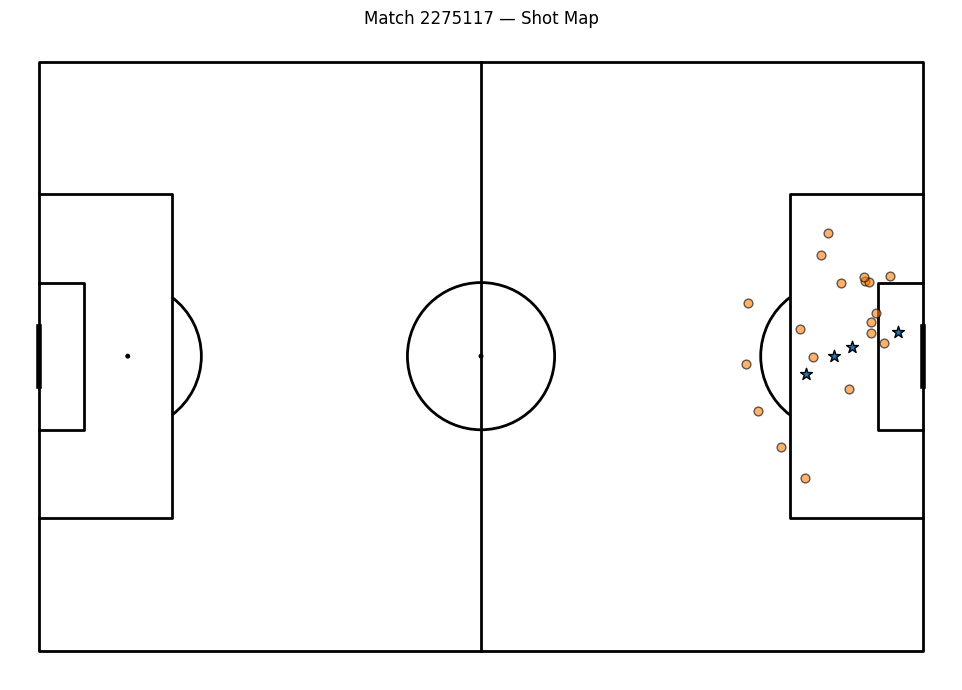

In [14]:
fig, ax = shot_map(shots, title=f"Match {match_id} — Shot Map")
VIZ.mkdir(parents=True, exist_ok=True)
out_png = VIZ / f"shot_map_{match_id}.png"
fig.savefig(out_png, dpi=200, bbox_inches="tight")
print("Saved shot map:", out_png)
plt.show()
